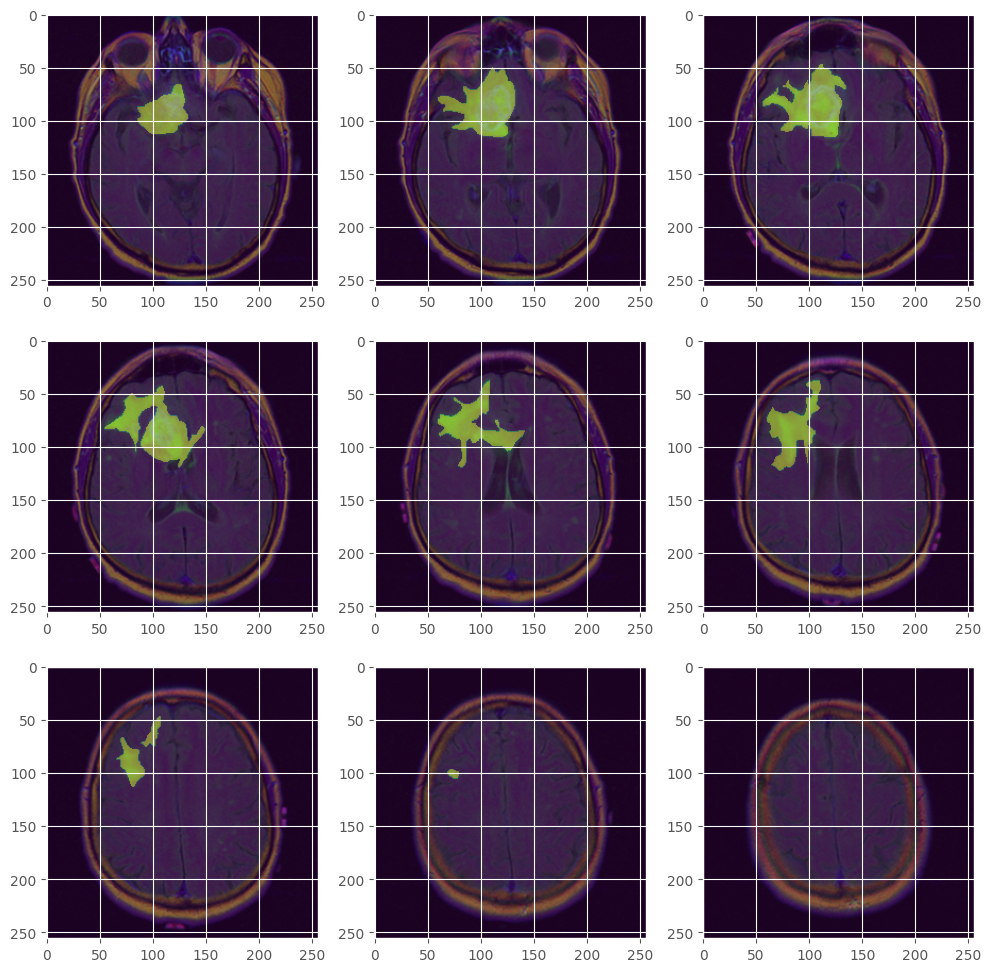

(3545, 2)
(187, 2)
(197, 2)
Found 3545 validated image filenames.
Found 3545 validated image filenames.
Epoch 1/7
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7303 - dice_coefficients: 0.0513 - iou: 0.0275 - loss: -0.0513Found 187 validated image filenames.
Found 187 validated image filenames.

Epoch 1: val_loss improved from inf to -0.03832, saving model to unet_brain_mri_seg.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - binary_accuracy: 0.7313 - dice_coefficients: 0.0514 - iou: 0.0276 - loss: -0.0514 - val_binary_accuracy: 0.7773 - val_dice_coefficients: 0.0383 - val_iou: 0.0204 - val_loss: -0.0383
Epoch 2/7
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9663 - dice_coefficients: 0.1065 - iou: 0.0588 - loss: -0.1066
Epoch 2: val_loss improved from -0.03832 to -0.05387, saving model to unet_brain_mri_seg.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - binary_accuracy: 0.9664 - dice_coefficients: 0.1066 - iou: 0.0588 - loss: -0.1067 - val_binary_accu

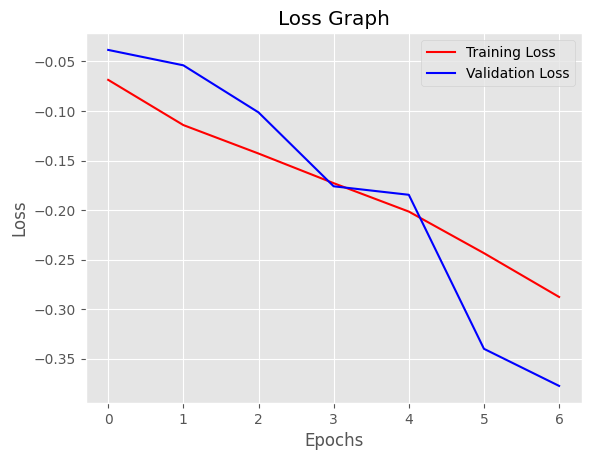

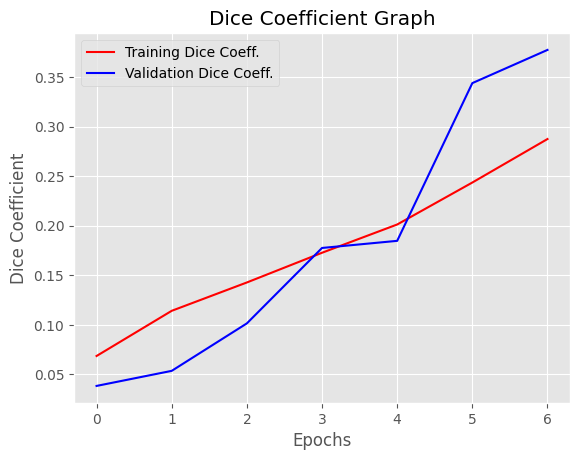

Found 197 validated image filenames.
Found 197 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - binary_accuracy: 0.9959 - dice_coefficients: 0.2981 - iou: 0.1856 - loss: -0.2981
Test Loss: -0.3195621073246002
Test IOU: 0.9953867793083191
Test Dice Coeff: 0.19982671737670898
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


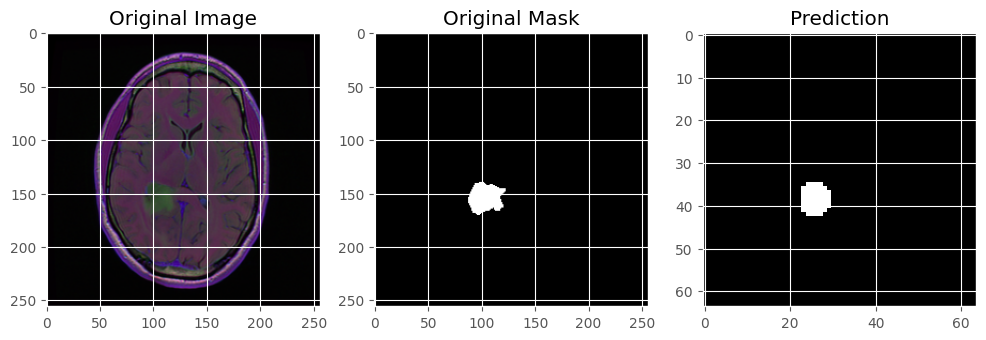

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


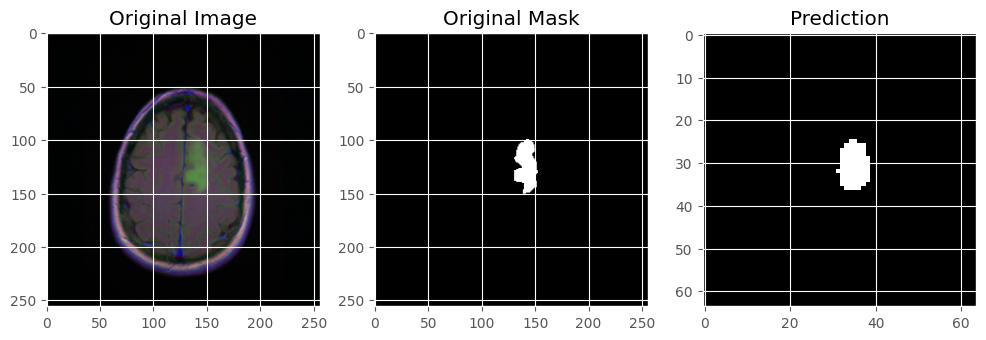

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


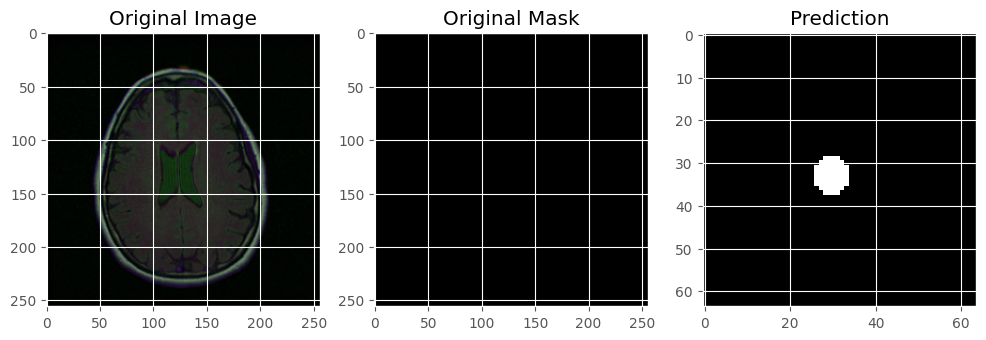

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


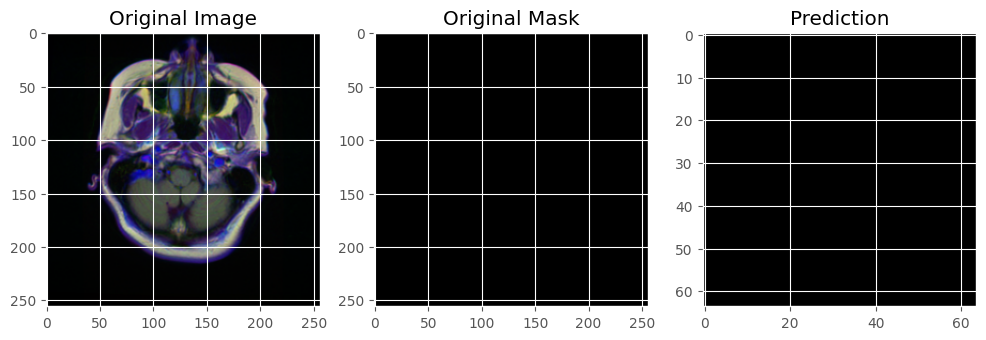

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


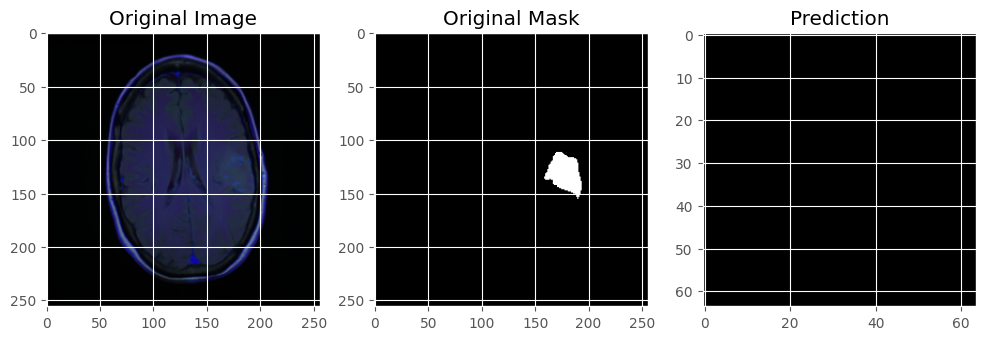

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Update image dimensions
im_width = 64
im_height = 64

# File paths
image_filename_train = []
mask_files = glob(pathname=r'D:\pattern\Brain-MRI-Segmentation-main\kaggle_3m\*\*_mask*')
for i in mask_files:
    image_filename_train.append(i.replace('_mask', ''))

# Plot sample images
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

plot_from_img_path(3, 3, image_filename_train, mask_files)

# Data preparation
df = pd.DataFrame(data={'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size=0.05)
df_train, df_val = train_test_split(df_train, test_size=0.05)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

# Updated train_generator function
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    target_size=(256, 256),
    seed=1,
):
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Normalize and process images
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

def normalize_and_diagnose(img, mask):
    img = img / 256.0
    mask = mask / 256.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return img, mask

def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

# Simplified U-Net model
def unet(input_size=(im_width, im_height, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)

    up5 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn4), conv3], axis=3)
    conv5 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up5)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv2], axis=3)
    conv6 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv1], axis=3)
    conv7 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    conv8 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn7)

    return Model(inputs=[inputs], outputs=[conv8])

# Training parameters
EPOCHS = 7
BATCH_SIZE = 32
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE, train_generator_args, target_size=(im_height, im_width))
test_gen = train_generator(df_val, BATCH_SIZE, dict(), target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

# Update optimizer initialization
opt = Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.keras', verbose=1, save_best_only=True)]

# Ensure steps_per_epoch and validation_steps are integers
steps_per_epoch = len(df_train) // BATCH_SIZE
validation_steps = len(df_val) // BATCH_SIZE

history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=test_gen,
                    validation_steps=validation_steps)

# Plot training history
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(train_loss_list, 'r-', label='Training Loss')
plt.plot(test_loss_list, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(train_dice_coeff_list, 'r-', label='Training Dice Coeff.')
plt.plot(test_dice_coeff_list, 'b-', label='Validation Dice Coeff.')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient Graph')
plt.legend()
plt.show()

# Load the best model
model = load_model('unet_brain_mri_seg.keras', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients})

# Evaluate on the test set
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) // BATCH_SIZE)
print('Test Loss:', results[0])
print('Test IOU:', results[1])
print('Test Dice Coeff:', results[2])

# Predict and visualize results
for i in range(5):  # Reduced number of samples for quick visualization
    index = np.random.randint(0, len(df_test.index))
    img_path = df_test['image_filename_train'].iloc[index]
    mask_path = df_test['mask'].iloc[index]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (im_height, im_width))
    img = img / 255.0
    img = img[np.newaxis, :, :, :]

    pred_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title("Original Image")ذ11
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5, cmap='gray')
    plt.title("Prediction")
    plt.show()
